In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%matplotlib inline

In [3]:
sns.set(style="darkgrid")

## Read the data

In [4]:
hands = pd.read_csv("hands6.csv")

In [5]:
games = pd.read_csv("games6.csv")

### Test plots

## Basic hands analysis

### State statistics

A histogram with x labels indicate which state is which.

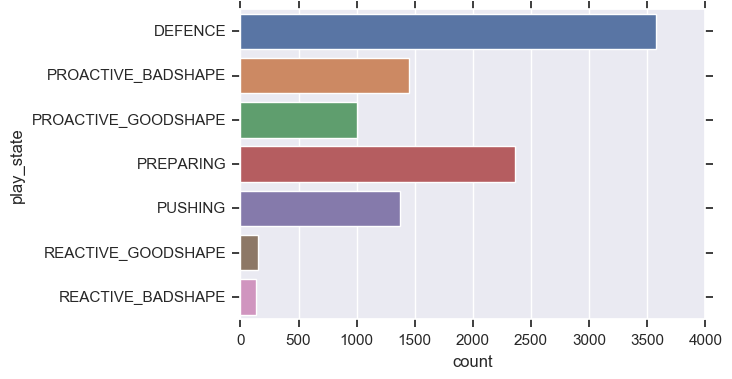

In [6]:
sns.countplot(y=hands["play_state"])

### State boxplot
I need to clearly see the average EV of each state.

Note that the "REACTIVE" data is too less. Not enough to adjust the algorithm.

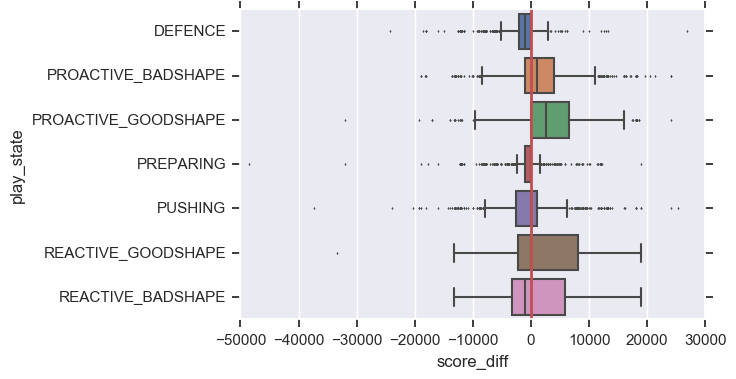

In [7]:
sns.boxplot(x="score_diff", y="play_state", data=hands, fliersize=1)
plt.axvline(color='r', linewidth=2)

### Score and meld times

(-10000, 10000)

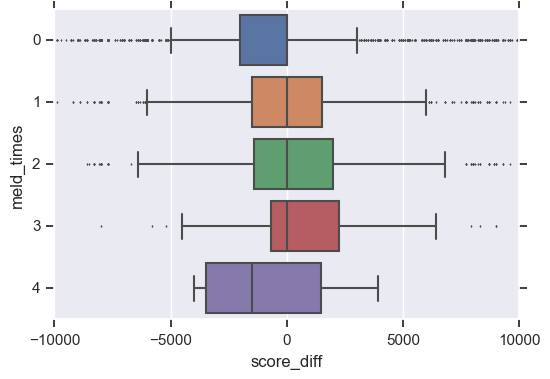

In [8]:
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands, fliersize=1)
ax.set_xlim(-10000, 10000)

### Defence when have melds

(-10000, 10000)

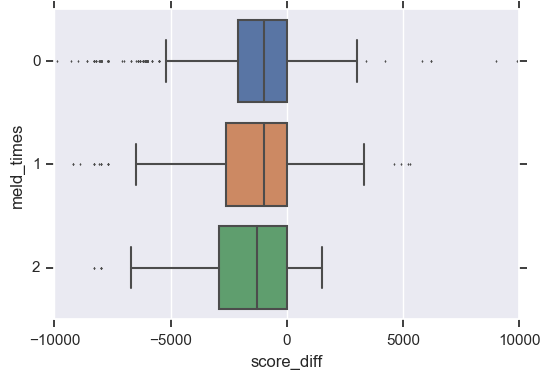

In [9]:
## defence when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] == "DEFENCE") & (hands["meld_times"] < 3)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Offense when have melds

(-10000, 10000)

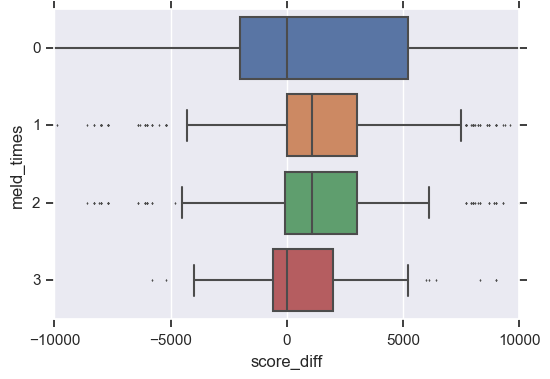

In [10]:
## offense when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] != "DEFENCE") & (hands["play_state"] != "PREPARING") & (hands["meld_times"] < 4)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Score and reach

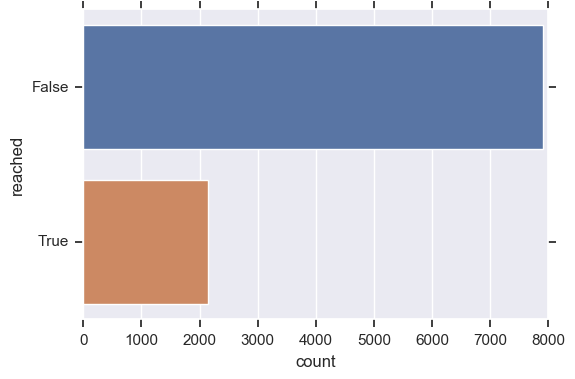

In [11]:
sns.countplot(y="reached", data=hands)

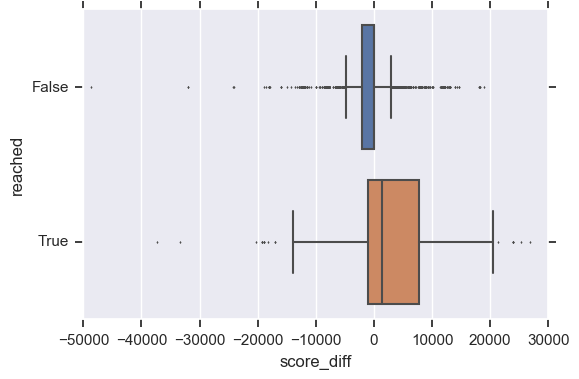

In [12]:
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands, fliersize=1)

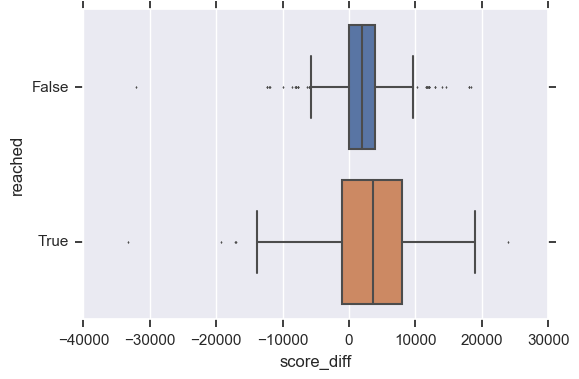

In [13]:
## GoodShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_GOODSHAPE") | (hands["play_state"]=="REACTIVE_GOODSHAPE")], fliersize=1)

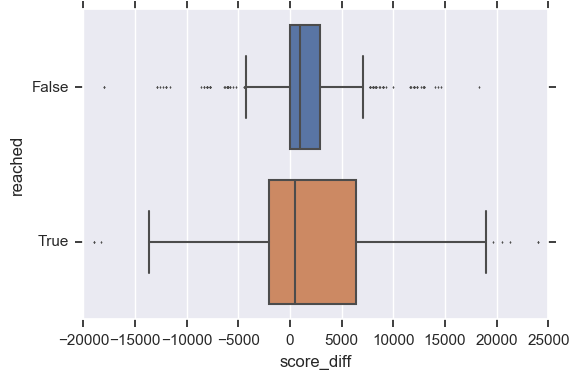

In [14]:
## BadShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_BADSHAPE") | (hands["play_state"]=="REACTIVE_BADSHAPE")], fliersize=1)

In hands2, the EV for badshape offense shows that reached is lower than unreached. After reaching condition for bad shape hands is tuned, this will be better.

### About game results

In [15]:
final_position = games["final_position"]
south_position = games["south_position"]

In [16]:
## south position ratio calculated
south_position_ratio = [(south_position==i).mean() for i in range(1,5)]
south_position_ratio

[0.2040358744394619,
 0.2522421524663677,
 0.2836322869955157,
 0.2600896860986547]

In [17]:
## final position ratio calculated
position_ratio = [(final_position==i).mean() for i in range(1,5)]
position_ratio

[0.18161434977578475,
 0.26681614349775784,
 0.29260089686098656,
 0.2589686098654709]

In [18]:
## Final Rate
current_rate = 1500

## Final Dan
i = 1
current_pt = 200
for play_count in range(3000):
    
    # change this to change the gamemode
    upper_dan = True
    phoenix = True
    
    delta_pt = [60, 15, 0]
    avg_rate = 1700
    if i >= 4 and current_rate >= 1800 and upper_dan:
        delta_pt = [75, 30, 0]
        avg_rate = 1900
    if i >= 7 and current_rate >= 2000 and phoenix:
        delta_pt = [90, 45, 0]
        avg_rate = 2100
    
    delta_pt.append(- (30 + i * 15))
    
    current_pt += np.dot(np.float32(delta_pt), position_ratio)
    delta_rate = np.dot(np.array(position_ratio), np.array([30, 10, -10, -30]))
    delta_rate += (avg_rate - current_rate) / 40
    current_rate += 0.2 * delta_rate
    
    if current_pt > i * 400:
        i += 1
        current_pt = i * 200
    elif current_pt < 0:
        i -= 1
        current_pt = i * 200
        
    if i > 10:
        print("Achieve 天凤 with play count {}".format(play_count))
        break
        
print("Final dan: {} with pt {}".format(i, current_pt))
print("Final rate: {}".format(current_rate))

Final dan: 2 with pt 281.14349775784535
Final rate: 1596.8609580112143


### South position and final position

In [19]:
_, row = next(games.iterrows())

In [20]:
pos_diff = np.zeros([4, 4])
for _, row in games.iterrows():
    pos_diff[row["final_position"]-1,row["south_position"]-1]+=1

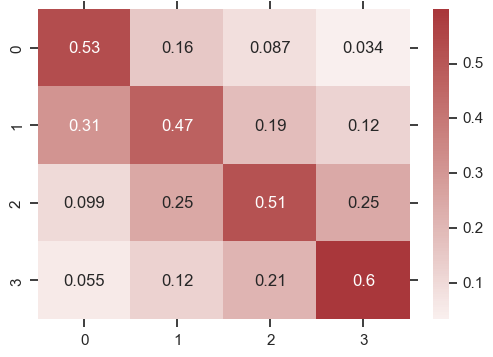

In [21]:
sns.heatmap(pos_diff/pos_diff.sum(axis=0), center=0, cmap="vlag", annot=True)

In [22]:
# score data preprocessing
score_preprocess = lambda x: int("".join(x.split(",")))
games["south_score"] = games["south_score"].apply(score_preprocess)
games["final_score"] = games["final_score"].apply(score_preprocess)

In [23]:
# Mean score
print("South main:", games["south_score"].mean(), games["south_position"].mean())
print("Final main:", games["final_score"].mean(), games["final_position"].mean())

South main: 23906.39013452915 2.5997757847533634
Final main: 22623.54260089686 2.6289237668161434


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


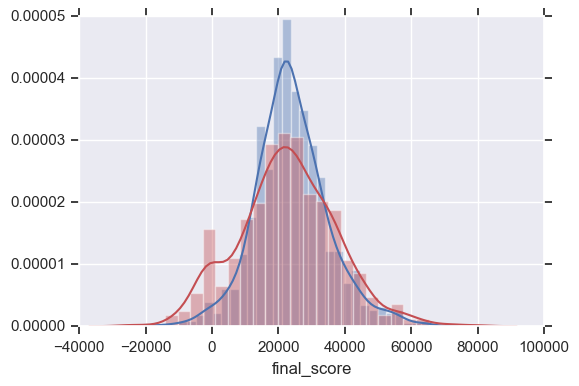

In [24]:
ax = sns.distplot(games["south_score"])
sns.distplot(games["final_score"], color="r", ax=ax)

## Defence

In [25]:
defence_hands = hands[hands["play_state"] == "DEFENCE"]

In [26]:
defence_hands.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
0,0,23000.0,-2000.0,DEFENCE,7,0,False,False,2019022002gm-0089-0000-2236eae8&tw=3,0,2,2
1,1,23000.0,0.0,DEFENCE,11,0,False,False,2019022002gm-0089-0000-2236eae8&tw=3,1,2,2
3,3,28300.0,-3000.0,DEFENCE,4,0,False,False,2019022002gm-0089-0000-2236eae8&tw=3,2,2,2
6,6,35500.0,0.0,DEFENCE,7,1,False,True,2019022002gm-0089-0000-2236eae8&tw=3,3,2,2
8,8,30400.0,-2100.0,DEFENCE,2,0,False,False,2019022002gm-0089-0000-2236eae8&tw=3,4,2,2
14,14,39000.0,-2000.0,DEFENCE,12,1,False,False,2019022003gm-0089-0000-3eb1d4b4&tw=3,2,1,1
19,19,50100.0,-4000.0,DEFENCE,7,0,False,False,2019022003gm-0089-0000-3eb1d4b4&tw=3,6,1,1
21,21,51600.0,-4000.0,DEFENCE,10,0,False,True,2019022003gm-0089-0000-3eb1d4b4&tw=3,7,1,1
23,23,23000.0,-2000.0,DEFENCE,9,0,False,True,2019022003gm-0089-0000-52f2da6f&tw=1,1,4,4
24,24,23000.0,0.0,DEFENCE,6,0,False,False,2019022003gm-0089-0000-52f2da6f&tw=1,2,4,4


In [27]:
print("Defence mean score diff:", defence_hands["score_diff"].mean())

Defence mean score diff: -1588.401341531582


In [28]:
print("Lose big points when defence:", len(defence_hands[defence_hands["score_diff"] <= -6000])/len(defence_hands))

Lose big points when defence: 0.0718278367803242


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-10000, 250)

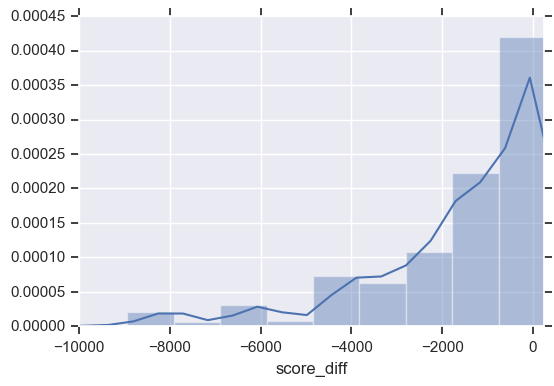

In [29]:
sns.distplot(defence_hands["score_diff"]).set_xlim(-10000, 250)

## Reasons why it got the 4th place

In [30]:
games_4th = games[games["final_position"] == 4]

In [31]:
hands_4th = hands[hands["final_position"] == 4]

### Play state with big score loss

In [32]:
hands_4th_bigloss = hands_4th[hands_4th["score_diff"] <= -6000]

In [33]:
hands_4th_bigloss.shape

(340, 12)

In [34]:
len(hands_4th_bigloss)/len(hands)

0.03381066030230708

In [35]:
hands_4th_bigloss.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
106,106,12200.0,-12300.0,PROACTIVE_BADSHAPE,6,1,False,True,2019022006gm-0089-0000-3723faae&tw=2,6,4,4
142,142,4900.0,-12300.0,PUSHING,0,0,False,False,2019022008gm-0089-0000-f0454095&tw=0,7,3,4
252,252,12000.0,-13000.0,PROACTIVE_BADSHAPE,9,0,True,False,2019022013gm-0089-0000-3fa0b836&tw=0,1,4,4
259,259,-2900.0,-8000.0,PUSHING,0,1,False,False,2019022013gm-0089-0000-3fa0b836&tw=0,5,4,4
297,297,21400.0,-8000.0,DEFENCE,4,0,False,False,2019022015gm-0089-0000-20ec8498&tw=2,1,4,4
300,300,10300.0,-6100.0,PUSHING,0,2,False,False,2019022015gm-0089-0000-20ec8498&tw=2,3,4,4
304,304,100.0,-12000.0,PUSHING,0,1,False,False,2019022015gm-0089-0000-20ec8498&tw=2,5,4,4
346,346,13500.0,-9000.0,PROACTIVE_BADSHAPE,3,0,True,False,2019022017gm-0089-0000-3083c1b3&tw=3,4,3,4
348,348,-3400.0,-13000.0,PUSHING,0,0,True,False,2019022017gm-0089-0000-3083c1b3&tw=3,6,3,4
462,462,15700.0,-8300.0,PREPARING,0,0,False,False,2019022021gm-0089-0000-6b153dc7&tw=3,1,4,4


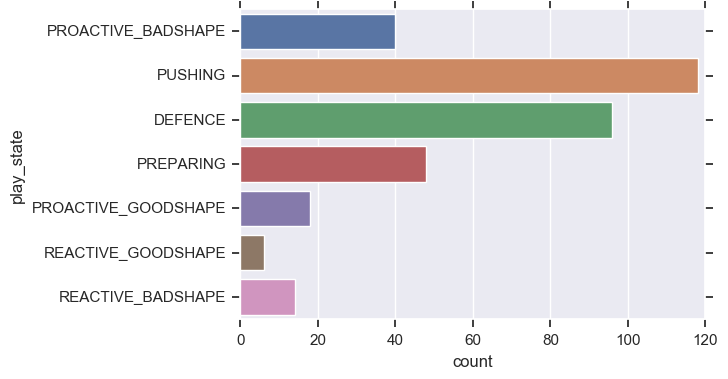

In [36]:
sns.countplot(y="play_state", data=hands_4th_bigloss)

### Category with south position

In [37]:
hands_S4 = hands[(hands["south_position"] == 4) & (hands["final_position"] == 4)]
hands_NS4 = hands[(hands["south_position"] != 4) & (hands["final_position"] == 4)]
print("South 4 final 4:", len(hands_S4)/len(hands))
print("South not 4 final 4:", len(hands_NS4)/len(hands))

South 4 final 4: 0.14190533015115353
South not 4 final 4: 0.11963007159904535


### South 4 and final 4

In first 3 rounds, check which state cause big score loss.

In [38]:
hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)].head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
252,252,12000.0,-13000.0,PROACTIVE_BADSHAPE,9,0,True,False,2019022013gm-0089-0000-3fa0b836&tw=0,1,4,4
297,297,21400.0,-8000.0,DEFENCE,4,0,False,False,2019022015gm-0089-0000-20ec8498&tw=2,1,4,4
462,462,15700.0,-8300.0,PREPARING,0,0,False,False,2019022021gm-0089-0000-6b153dc7&tw=3,1,4,4
489,489,12200.0,-12300.0,PROACTIVE_GOODSHAPE,10,3,False,False,2019022022gm-0089-0000-43e04273&tw=3,0,4,4
521,521,18000.0,-7000.0,REACTIVE_GOODSHAPE,8,0,True,False,2019022100gm-0089-0000-aa32a293&tw=2,1,4,4
522,522,9000.0,-9000.0,REACTIVE_GOODSHAPE,5,0,True,False,2019022100gm-0089-0000-aa32a293&tw=2,1,4,4
724,724,10900.0,-11900.0,PREPARING,0,2,False,False,2019022108gm-0089-0000-e73c8541&tw=0,1,4,4
738,738,17000.0,-8000.0,DEFENCE,12,1,False,False,2019022109gm-0089-0000-7cb9a732&tw=2,0,4,4
740,740,9600.0,-6000.0,DEFENCE,13,0,False,False,2019022109gm-0089-0000-7cb9a732&tw=2,1,4,4
877,877,11700.0,-12300.0,PROACTIVE_GOODSHAPE,11,1,False,False,2019022115gm-0089-0000-40bd397b&tw=0,1,4,4


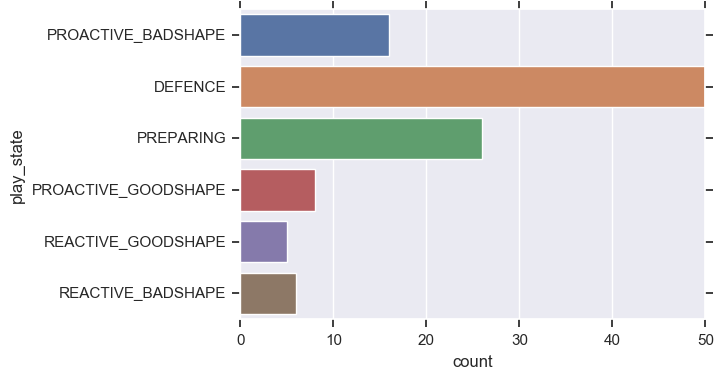

In [39]:
sns.countplot(y="play_state", data=hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)])

It seems like plenty of big score loss are caused by defence. Time to do some error analysis.

In [53]:
big_loss_early_hands = hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)]

In [55]:
big_loss_early_hands[big_loss_early_hands["play_state"] == "DEFENCE"]

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
297,297,21400.0,-8000.0,DEFENCE,4,0,False,False,2019022015gm-0089-0000-20ec8498&tw=2,1,4,4
738,738,17000.0,-8000.0,DEFENCE,12,1,False,False,2019022109gm-0089-0000-7cb9a732&tw=2,0,4,4
740,740,9600.0,-6000.0,DEFENCE,13,0,False,False,2019022109gm-0089-0000-7cb9a732&tw=2,1,4,4
1816,354,20000.0,-8000.0,DEFENCE,5,0,False,False,2019022018gm-0089-0000-93c19186&tw=2,1,4,4
1919,457,25000.0,-12000.0,DEFENCE,8,1,False,False,2019022022gm-0089-0000-b1e620cf&tw=0,1,4,4
2065,603,12600.0,-7000.0,DEFENCE,2,0,False,False,2019022105gm-0089-0000-cd471a1f&tw=1,0,4,4
2364,902,13000.0,-12000.0,DEFENCE,3,0,False,False,2019022118gm-0089-0000-6c3f3377&tw=1,0,4,4
2469,1007,19000.0,-6000.0,DEFENCE,12,0,False,True,2019022123gm-0089-0000-d498db76&tw=0,0,4,4
2560,1098,16500.0,-7700.0,DEFENCE,6,0,False,False,2019022202gm-0089-0000-9831b2e7&tw=3,1,4,4
2882,2,19000.0,-6000.0,DEFENCE,7,1,False,True,2019022002gm-0089-0000-46bce2f9&tw=0,0,4,4


In [56]:
S4_defence_game_indexes = big_loss_early_hands[big_loss_early_hands["play_state"] == "DEFENCE"]["game_index"].unique()

In [57]:
for game_index in S4_defence_game_indexes:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022015gm-0089-0000-20ec8498&tw=2

http://tenhou.net/3/?log=2019022109gm-0089-0000-7cb9a732&tw=2

http://tenhou.net/3/?log=2019022018gm-0089-0000-93c19186&tw=2

http://tenhou.net/3/?log=2019022022gm-0089-0000-b1e620cf&tw=0

http://tenhou.net/3/?log=2019022105gm-0089-0000-cd471a1f&tw=1

http://tenhou.net/3/?log=2019022118gm-0089-0000-6c3f3377&tw=1

http://tenhou.net/3/?log=2019022123gm-0089-0000-d498db76&tw=0

http://tenhou.net/3/?log=2019022202gm-0089-0000-9831b2e7&tw=3

http://tenhou.net/3/?log=2019022002gm-0089-0000-46bce2f9&tw=0

http://tenhou.net/3/?log=2019022018gm-0009-0000-0a6ddf7e&tw=2

http://tenhou.net/3/?log=2019022109gm-0089-0000-7a679e50&tw=1

http://tenhou.net/3/?log=2019022114gm-0089-0000-df4c2c66&tw=0

http://tenhou.net/3/?log=2019022117gm-0089-0000-012acdc1&tw=0

http://tenhou.net/3/?log=2019022118gm-0089-0000-7264bd51&tw=1

http://tenhou.net/3/?log=2019022119gm-0089-0000-391bb8a5&tw=0

http://tenhou.net/3/?log=2019022120gm-0009-0000-4cbd936

### South not 4 and final 4

See why there are big score losses in south rounds.

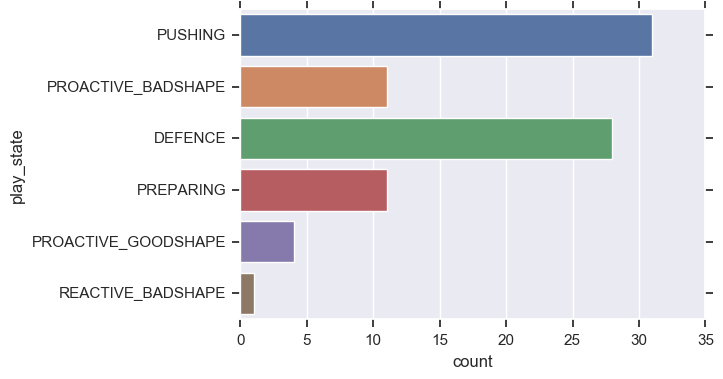

In [42]:
sns.countplot(y="play_state", data=hands_NS4[(hands_NS4["round_num"] >= 4) & (hands_NS4["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


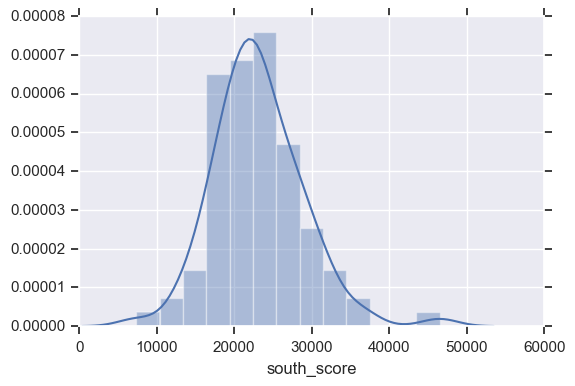

In [43]:
sns.distplot(games[(games["south_position"] != 4) & (games["final_position"] == 4)]["south_score"])

In [44]:
for game_index in hands_NS4["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022005gm-0089-0000-4c7df4cc&tw=3

http://tenhou.net/3/?log=2019022008gm-0089-0000-f0454095&tw=0

http://tenhou.net/3/?log=2019022017gm-0089-0000-3083c1b3&tw=3

http://tenhou.net/3/?log=2019022117gm-0089-0000-f9b7798d&tw=0

http://tenhou.net/3/?log=2019022122gm-0089-0000-cb0ec1f4&tw=1

http://tenhou.net/3/?log=2019022201gm-0089-0000-31e3408b&tw=0

http://tenhou.net/3/?log=2019022207gm-0089-0000-1037981d&tw=3

http://tenhou.net/3/?log=2019022207gm-0089-0000-5ef4654d&tw=3

http://tenhou.net/3/?log=2019022208gm-0089-0000-838284c1&tw=3

http://tenhou.net/3/?log=2019022210gm-0089-0000-1cb20593&tw=3

http://tenhou.net/3/?log=2019022210gm-0089-0000-e8a5759e&tw=1

http://tenhou.net/3/?log=2019022212gm-0089-0000-3cc9e671&tw=0

http://tenhou.net/3/?log=98857

http://tenhou.net/3/?log=2019022006gm-0089-0000-2393cc1f&tw=1

http://tenhou.net/3/?log=2019022014gm-0089-0000-cd5fb8f9&tw=0

http://tenhou.net/3/?log=2019022016gm-0089-0000-90a062a4&tw=1

http://tenhou.net/3/?lo

### South 1 and final not 1

In [45]:
hands_S1 = hands[(hands["south_position"] == 1) & (hands["final_position"] != 1)]

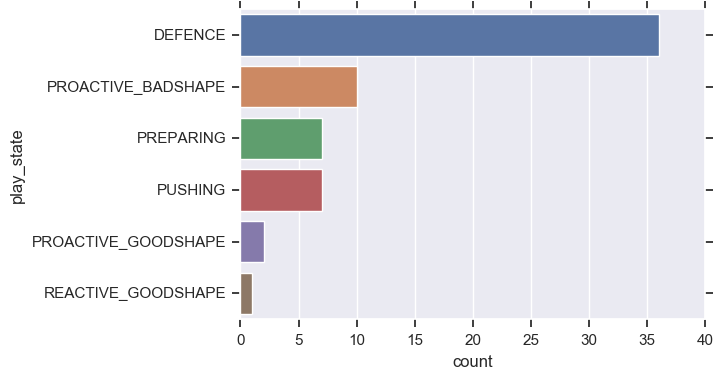

In [46]:
# more than -3900
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -3900)])

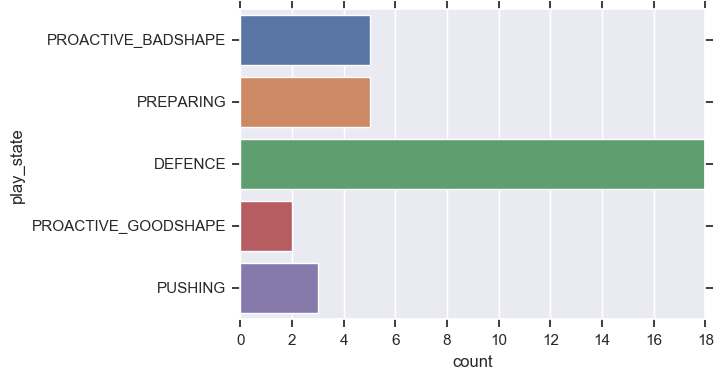

In [47]:
# more than -6000
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


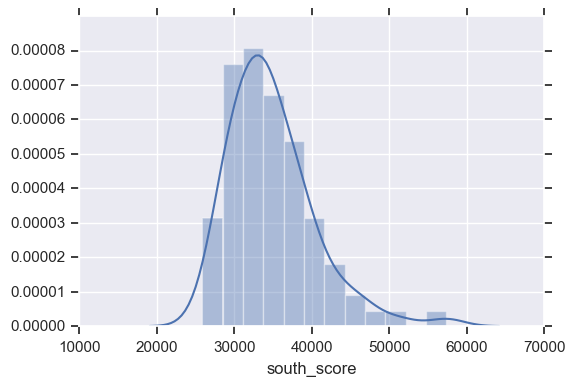

In [48]:
sns.distplot(games[(games["south_position"] == 1) & (games["final_position"] != 1)]["south_score"])

In [49]:
for game_index in hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)]["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022009gm-0089-0000-7c795ef5&tw=1

http://tenhou.net/3/?log=2019022110gm-0089-0000-8fc4357a&tw=0

http://tenhou.net/3/?log=2019022112gm-0089-0000-f93c701b&tw=2

http://tenhou.net/3/?log=2019022118gm-0089-0000-3a48f0c9&tw=3

http://tenhou.net/3/?log=2019022120gm-0089-0000-4f644eab&tw=3

http://tenhou.net/3/?log=2019022019gm-0089-0000-c1bc0a2e&tw=1

http://tenhou.net/3/?log=2019022021gm-0089-0000-bb8d261e&tw=0

http://tenhou.net/3/?log=2019022211gm-0089-0000-47a71868&tw=2

http://tenhou.net/3/?log=2019022213gm-0089-0000-94fbcfab&tw=2

http://tenhou.net/3/?log=2019022215gm-0089-0000-0e270beb&tw=2

http://tenhou.net/3/?log=2019022014gm-0009-0000-84a49932&tw=1

http://tenhou.net/3/?log=2019022102gm-0089-0000-e1c42325&tw=0

http://tenhou.net/3/?log=2019022107gm-0089-0000-f141b2dd&tw=1

http://tenhou.net/3/?log=2019022207gm-0089-0000-7bf5b6ce&tw=1

http://tenhou.net/3/?log=2019022012gm-0089-0000-ca33edef&tw=1

http://tenhou.net/3/?log=2019022020gm-0089-0000-18e31f0

## Error Analysis

In [50]:
games.head()

,Unnamed: 0,game_index,south_score,final_score,south_position,final_position
0,0,2019022002gm-0089-0000-2236eae8&tw=3,35500,31700,2,2
1,1,2019022003gm-0089-0000-3eb1d4b4&tw=3,50600,51600,1,1
2,2,2019022003gm-0089-0000-52f2da6f&tw=1,16700,21000,4,4
3,3,2019022004gm-0089-0000-4db85eb8&tw=0,23400,22400,3,3
4,4,2019022004gm-0089-0000-7294c491&tw=3,28800,45100,2,1


In [51]:
game_indexes_4 = games[games["final_position"]==4]["game_index"]

In [52]:
for game_index in game_indexes_4:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022003gm-0089-0000-52f2da6f&tw=1

http://tenhou.net/3/?log=2019022005gm-0089-0000-4c7df4cc&tw=3

http://tenhou.net/3/?log=2019022006gm-0089-0000-3723faae&tw=2

http://tenhou.net/3/?log=2019022008gm-0089-0000-f0454095&tw=0

http://tenhou.net/3/?log=2019022013gm-0089-0000-3fa0b836&tw=0

http://tenhou.net/3/?log=2019022015gm-0089-0000-20ec8498&tw=2

http://tenhou.net/3/?log=2019022017gm-0089-0000-3083c1b3&tw=3

http://tenhou.net/3/?log=2019022021gm-0089-0000-6b153dc7&tw=3

http://tenhou.net/3/?log=2019022022gm-0089-0000-43e04273&tw=3

http://tenhou.net/3/?log=2019022100gm-0089-0000-aa32a293&tw=2

http://tenhou.net/3/?log=2019022103gm-0089-0000-0ff71549&tw=3

http://tenhou.net/3/?log=2019022108gm-0089-0000-b941b583&tw=3

http://tenhou.net/3/?log=2019022108gm-0089-0000-e73c8541&tw=0

http://tenhou.net/3/?log=2019022109gm-0089-0000-7cb9a732&tw=2

http://tenhou.net/3/?log=2019022115gm-0089-0000-40bd397b&tw=0

http://tenhou.net/3/?log=2019022116gm-0089-0000-f24d116